In [ ]:
def gaze_point(x,y,z):
    
    
    
    head_pose = head.get_current_joint_values()
    head_pose[0]=0.0
    head_pose[1]=0.0
    head.set_joint_value_target(head_pose)
    head.go()
    
    trans , rot = listener.lookupTransform('/map', '/head_rgbd_sensor_gazebo_frame', rospy.Time(0)) #
    
  #  arm_pose=arm.get_current_joint_values()
  #  arm_pose[0]=.1
  #  arm_pose[1]= -0.3
  #  arm.set_joint_value_target(arm_pose)
  #  arm.go()
    
    e =tf.transformations.euler_from_quaternion(rot)
    print('i am at',trans,np.rad2deg(e)[2])
    print('gaze goal',x,y,z)
    #tf.transformations.euler_from_quaternion(rot)


    x_rob,y_rob,z_rob,th_rob= trans[0], trans[1] ,trans[2] ,  e[2]


    D_x=x_rob-x
    D_y=y_rob-y
    D_z=z_rob-z

    D_th= np.arctan2(D_y,D_x)
    print('relative to robot',(D_x,D_y,np.rad2deg(D_th)))

    pan_correct= (- th_rob + D_th + np.pi) % (2*np.pi)

    if(pan_correct > np.pi):
        pan_correct=-2*np.pi+pan_correct
    if(pan_correct < -np.pi):
        pan_correct=2*np.pi+pan_correct

    if ((pan_correct) > .5 * np.pi):
        print ('Exorcist alert')
        pan_correct=.5*np.pi
    head_pose[0]=pan_correct
    tilt_correct=np.arctan2(D_z,np.linalg.norm((D_x,D_y)))

    head_pose [1]=-tilt_correct
    
    
    
    head.set_joint_value_target(head_pose)
    succ=head.go()
    return succ

## Setup

必要なライブラリをインポートして、初期化を行います。

Import the required libraries and initialize them:

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import ros_numpy
import rospy
import tf
from gazebo_ros import gazebo_interface
from sensor_msgs.msg import LaserScan, PointCloud2
from geometry_msgs.msg import Pose, Quaternion ,TransformStamped

import sys

from utils_notebooks import *

import cv2
import os


rvizを起動します．ロボットモデル、カメラ映像、ポイントクラウドが表示されています。

In [ ]:

rospy.init_node("recognition")


In [ ]:
rgbd = RGBD()
###clase rgbd para obtener mensajes de nube de puntos y de imagen

In [ ]:
listener = tf.TransformListener()
broadcaster= tf.TransformBroadcaster()
import moveit_commander
import moveit_msgs.msg

head = moveit_commander.MoveGroupCommander('head')
#whole_body=moveit_commander.MoveGroupCommander('whole_body_weighted')
arm =  moveit_commander.MoveGroupCommander('arm')

[ WARN] [1661205100.700354273]: Link hand_l_finger_vacuum_frame has visual geometry but no collision geometry. Collision geometry will be left empty. Fix your URDF file by explicitly specifying collision geometry.
[ WARN] [1661205100.706801689]: Link head_l_stereo_camera_link has visual geometry but no collision geometry. Collision geometry will be left empty. Fix your URDF file by explicitly specifying collision geometry.
[ WARN] [1661205100.706851422]: Link head_r_stereo_camera_link has visual geometry but no collision geometry. Collision geometry will be left empty. Fix your URDF file by explicitly specifying collision geometry.
[ WARN] [1661205100.708440673]: Group state 'neutral' doesn't specify all group joints in group 'arm'. wrist_ft_sensor_frame_joint is missing.
[ WARN] [1661205100.708486795]: Group state 'go' doesn't specify all group joints in group 'arm'. wrist_ft_sensor_frame_joint is missing.
[ WARN] [1661205100.844471107]: Kinematics solver doesn't support #attempts any

In [ ]:
arm.set_named_target('go')
arm.go()


True

In [ ]:
head.go(np.array((0,-.15*np.pi)))

True

# Qué es una imágen

# Cómo se forma

#modelo PInhole

In [ ]:
image=rgbd.get_image()  #dimensiones de la imagen
image.shape    # una matriz (arreglo tipo numpy) 480px por 680 px 3 canales

points= rgbd.get_points()    ###Similarmente la nube de puntos "corregida"

In [ ]:
image.dtype  ### TIPO E DATOS int sin signo de 8 bits

dtype('uint8')

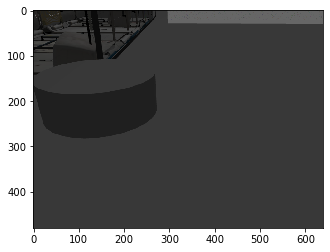

In [ ]:
plt.imshow(rgbd.get_image())

#canal R , G B rojo verde azul, existe otro espacio de colores, HSV Hue Saturation Value,
### para explorar este concepto usaremos open cv, y normalmente a open cv le gusta ordenar sus imagenes
###BGR, NO RGB... existe una función que realiza esta conversión.... pero simplemente hay que canviar el orden de los canales
### facilmente realizable en python

##Ejercicio en clase, Segmente la pelota y usando la informacion de la nube de puntos calcule un centroide de los puntos que la conforman

In [ ]:


im_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

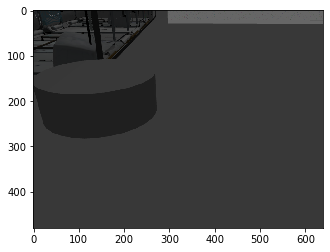

In [ ]:
plt.imshow(im_bgr)

In [ ]:
im_hsv = cv2.cvtColor(im_bgr, cv2.COLOR_BGR2HSV)#De forma similar podemos

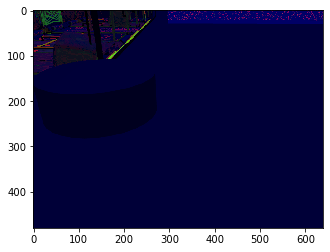

In [ ]:
plt.imshow(im_hsv)

In [ ]:
#La información de los canales ahora contiene la codificación de color en el canal 0 Hue. veamos 


(<matplotlib.image.AxesImage at 0x7f40d01f3d00>, dtype('uint8'))

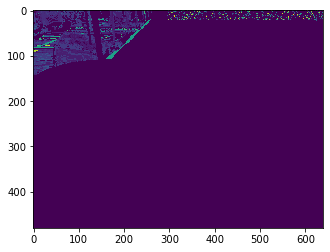

[ WARN] [1661205184.083203840, 2363.783000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2363.814000 according to authority unknown_publisher
[ WARN] [1661205184.083388021, 2363.783000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2363.814000 according to authority /pose_integrator
[ WARN] [1661205185.491584610, 2364.369000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2364.369000 according to authority /pose_integrator
[ WARN] [1661205185.494906852, 2364.369000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2364.369000 according to authority unknown_publisher
[ WARN] [1661205205.765975153, 2372.289000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2372.327000 according to authority unknown_publisher
[ WARN] [1661205205.766230911, 2372.289000000]: TF_REPEATED_DATA ignoring data with redundant timestam

In [ ]:
plt.imshow(im_hsv[:,:,0]) , im_hsv.dtype

##Ejercicio en clase, analizar los valores del canal cero de la imagen hsv. intentar encontrar 
##un valor que permita encontrar un color en particular (pelota de tenis, taza ,etc)
## PISTA valor de amarillo pelota tenis entre 30   y 50 

In [ ]:
h_min=0
h_max=15

region = (im_hsv > h_min) & (im_hsv < h_max)

In [ ]:
idx,idy=np.where(region[:,:,0] )


In [ ]:
mask= np.zeros((480,640))
mask[idx,idy]=255
plt.imshow(mask ,cmap='gray')

In [ ]:
#algunos pixeles aislados pueden interferir, por eso usando las operaciones morfológicas buscamos eliminarlas

In [ ]:
kernel = np.ones((5, 5), np.uint8)
eroded_mask=cv2.erode(mask,kernel)
dilated_mask=cv2.dilate(eroded_mask,kernel)

plt.imshow(dilated_mask,cmap='gray')

In [ ]:
points.shape

In [ ]:
contours, hierarchy = cv2.findContours(dilated_mask.astype('uint8'),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

In [ ]:
for contour in contours:
    M = cv2.moments(contour) #MOMENTOS ESADISTICOS DE LA IMAGEN
    
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    boundRect = cv2.boundingRect(contour)
    image2=cv2.rectangle(im_hsv,(boundRect[0], boundRect[1]),(boundRect[0]+boundRect[2], boundRect[1]+boundRect[3]), (255,255,255), 2)
    cv2.circle(image2, (cX, cY), 5, (255, 255, 255), -1)
    cv2.putText(image2, "centroid_"+str(cX)+','+str(cY)    ,    (cX - 50, cY - 25)   ,cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 255, 255), 2)
    


In [ ]:
plt.imshow(cv2.cvtColor( image2, cv2.COLOR_HSV2RGB))

#AHORA USEMOS LOS BOUNDING BOXES OBTENIDOS 
#PARA CALCULAR EL CENTROIDE DE LOS PUNTOS CONTENIDOS 

In [ ]:

for contour in contours:
    xyz=[]
    M = cv2.moments(contour) #MOMENTOS ESADISTICOS DE LA IMAGEN
    
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    boundRect = cv2.boundingRect(contour)

    for jy in range (boundRect[0], boundRect[0]+boundRect[2]):
        for ix in range(boundRect[1], boundRect[1]+boundRect[3]):
            aux=(np.asarray((points['x'][ix,jy],points['y'][ix,jy],points['z'][ix,jy])))
            if np.isnan(aux[0]) or np.isnan(aux[1]) or np.isnan(aux[2]):
                'reject point'
            else:
                xyz.append(aux)

    xyz=np.asarray(xyz)
    cent=xyz.mean(axis=0)

In [ ]:
#centroide de los puntos en la coordenada  respectiva a lsensor
print (cent)

In [ ]:
x,y,z=cent
if np.isnan(x) or np.isnan(y) or np.isnan(z):
    print('nan')
else:
    broadcaster.sendTransform((x,y,z),(0,0,0,1), rospy.Time.now(), 'Object',"head_rgbd_sensor_link")

In [ ]:
###  Usando tf  calculamos la pose con marco de referencia en head rgbd sensor link
#### Use RVIZ para desplegar este

In [ ]:
#Posición relativa al sensor

In [ ]:
mask